In [1]:
# Test the model
# import the necessary libraries

import numpy as np
import pandas as pd
import joblib

In [50]:
# Load the model
model = joblib.load('../models/genre_model_based_number_of_rating.pkl')

# Load the encoder
age_encoder = joblib.load('../models/age_ohe.pkl')
occupation_encoder = joblib.load('../models/occupation_ohe.pkl')

# Load the genre columns
genre_columns = joblib.load('../models/genre_columns.pkl')

# Load the age map
age_map = joblib.load('../models/age_map.pkl')

# Load the links
links = pd.read_csv('../data/raw/ml-25m/links.csv')

In [3]:
# Define the function for age range mapping
def age_map_convertor(age):
    if age <= 18:
        return 1
    elif age <= 24:
        return 18
    elif age <= 34:
        return 25
    elif age <= 44:
        return 35
    elif age <= 49:
        return 45
    elif age <= 55:
        return 50
    else:
        return 56

# Define the function to prepare the data
def prepare_data(age, occupation, gender):
    # Map the age to the corresponding range key
    age_str = age_map[age_map_convertor(age)]

    # Ensure that age and occupation are in 2D format
    age_input = np.array(age_str).reshape(1, -1)  # Convert age to a 2D array
    occupation_input = np.array(occupation).reshape(1, -1)  # Convert occupation to a 2D array

    # Transform the data using the encoder
    age_encoded = age_encoder.transform(age_input).toarray()  # Convert sparse matrix to dense array
    occupation_encoded = occupation_encoder.transform(occupation_input).toarray()  # Convert sparse matrix to dense array

    # Combine all features into a single array
    input_features = np.hstack([gender, age_encoded.flatten(), occupation_encoded.flatten()])

    # Reshape input to 2D array as expected by the model
    input_features = input_features.reshape(1, -1)

    feature_names = ['gender'] + list(age_encoder.get_feature_names_out(['AgeRange'])) + list(occupation_encoder.get_feature_names_out(['Occupation']))
    input_features_df = pd.DataFrame(input_features, columns=feature_names)
    
    return input_features_df

In [4]:
# Prepare a sample input
gender = 1  # 0 for Male, 1 for Female
age = 28  # Age 
occupation = "executive/managerial"  # Occupation code for "college/grad student"

In [5]:
# Prepare the input data
input_features = prepare_data(age, occupation, gender)

In [6]:
# Make predictions
predictions = model.predict(input_features)

In [7]:
# Convert binary predictions to genre labels
predicted_genre_labels = [genre for genre, flag in zip(genre_columns, predictions[0]) if flag == 1]

# Display the predicted genres
print("Predicted Genres:", predicted_genre_labels)

Predicted Genres: ['Action', 'Comedy', 'Drama', 'Romance', 'Thriller']


In [8]:
# Load your movies dataset
movies_ml_25m = pd.read_csv('../data/raw/ml-25m/movies.csv')

In [9]:
import joblib
from scipy.sparse import csr_matrix

# Load the vectorizer and similarity matrix
sparse_similarity_matrix = csr_matrix(joblib.load('../models/cosine_similarity_matrix.joblib', mmap_mode='r'))

# Function to get recommendations for a specific movie
def get_recommendations(movie_id, movie_indices, top_n=10):
    # Create reverse mapping from indices to movieId
    index_to_movie_id = {v: k for k, v in movie_indices.items()}
    
    idx = movie_indices.get(movie_id)
    if idx is None:
        return []

    # Access the row from the memory-mapped file
    sim_scores = sparse_similarity_matrix[idx].toarray().flatten()
    sorted_indices = np.argsort(sim_scores)[::-1]

    # Get top N recommendations, skipping the movie itself
    top_similar_indices = [index_to_movie_id[j] for j in sorted_indices[:top_n] if j != idx]
    return top_similar_indices

movie_indices = {movieId: idx for idx, movieId in enumerate(movies_ml_25m['movieId'])}


recommendations = get_recommendations(1, movie_indices, top_n=10)


In [10]:
recommendations

[3114, 2355, 4886, 78499, 126405, 201588, 157296, 175831, 6377]

In [24]:
# Helper function to find movie ID by title
def find_movie_ids_by_name(movie_name, movie_dataset=movies_ml_25m):
    # Convert the movie name to lowercase for case-insensitive search
    movie_name_lower = movie_name.lower()

    # Find all movies with names containing the search string
    matching_movies = movie_dataset[movie_dataset['title'].str.lower().str.contains(movie_name_lower)]

    # Return the movie IDs
    return matching_movies['movieId'].tolist()

In [25]:
# Helper function to get movie id array for user input for get_movie_recommendations
def get_movie_ids(movie_input, movie_dataset=movies_ml_25m):
    movie_ids = []
    # Check if the movie_input is array or not
    if isinstance(movie_input, list):
        for movie in movie_input:
            # Determine if input is a movie ID or name
            if isinstance(movie, int):
                # Input is a movie ID
                movie_ids.append(movie)
            elif isinstance(movie, str):
                # Input is a movie name
                movie_ids.extend(find_movie_ids_by_name(movie, movie_dataset))
            else:
                return "Invalid input type. Please provide a movie ID (int) or movie name (str)."
    elif isinstance(movie_input, int) or isinstance(movie_input, str):
        if isinstance(movie_input, int):
            # Input is a movie ID
            movie_ids = [movie_input]
        elif isinstance(movie_input, str):
            # Input is a movie name
            movie_ids = find_movie_ids_by_name(movie_input, movie_dataset)
            # If no movie IDs are found, return a message
            if not movie_ids:
                return f"No movie with the name '{movie_input}' exists. Please try again."
    else:
        return "Invalid input type. Please provide a movie ID (int), movie name (str) or list of movie IDs/names."

    return movie_ids

In [20]:
# Function to get movie recommendations
def get_movie_recommendations(movie_input, top_n=10, movie_dataset=movies_ml_25m, link_dataset=links):
    # Get the movie IDs
    movie_ids = get_movie_ids(movie_input, movie_dataset)

    movie_indices_local = {movieId: idx for idx, movieId in enumerate(movie_dataset['movieId'])}

    # Store recommendations for each movie ID
    recommendations_dict = {}

    for movie_id in movie_ids:
        # Get the movie name
        movie_name = movie_dataset[movie_dataset['movieId'] == movie_id]['title'].values[0]

        # Get the recommendations
        _recommendations = get_recommendations(movie_id, movie_indices=movie_indices_local, top_n=top_n)

        # Prepare a list to store details for each recommended movie
        recommended_movies_info = []

        # Get the movie names, genres, and IDs of the recommendations
        for rec_movie_id in _recommendations:
            recommended_movie = movie_dataset[movie_dataset['movieId'] == rec_movie_id]
            if not recommended_movie.empty:
                movie_info = {
                    'movie_name': recommended_movie['title'].values[0],
                    'genre': recommended_movie['genres'].values[0],
                    'movieId': rec_movie_id,
                    'imdb_id': link_dataset[link_dataset['movieId'] == rec_movie_id]['imdbId'].values[0],
                    'tmdb_id': link_dataset[link_dataset['movieId'] == rec_movie_id]['tmdbId'].values[0]
                }
                recommended_movies_info.append(movie_info)

        # Store the output for each movie
        recommendations_dict[movie_id] = {
            'movie_name': movie_name,
            'recommended_movies': recommended_movies_info
        }

    return recommendations_dict

# Example usage:
movie_ids = [1, 2, 3]  # Or just a single ID like 1
# recommendations = get_movie_recommendations(movie_ids, top_n=10)


In [43]:
# Get recommendations for the movie
movie_id = 1
output = get_movie_recommendations(movie_id, top_n=10)

# Display the output
output.get(1)

{'movie_name': 'Toy Story (1995)',
 'recommended_movies': [{'movie_name': 'Toy Story 2 (1999)',
   'genre': 'Adventure|Animation|Children|Comedy|Fantasy',
   'movieId': 3114,
   'imdb_id': 120363,
   'tmdb_id': 863.0},
  {'movie_name': "Bug's Life, A (1998)",
   'genre': 'Adventure|Animation|Children|Comedy',
   'movieId': 2355,
   'imdb_id': 120623,
   'tmdb_id': 9487.0},
  {'movie_name': 'Monsters, Inc. (2001)',
   'genre': 'Adventure|Animation|Children|Comedy|Fantasy',
   'movieId': 4886,
   'imdb_id': 198781,
   'tmdb_id': 585.0},
  {'movie_name': 'Toy Story 3 (2010)',
   'genre': 'Adventure|Animation|Children|Comedy|Fantasy|IMAX',
   'movieId': 78499,
   'imdb_id': 435761,
   'tmdb_id': 10193.0},
  {'movie_name': 'The Adventures of André and Wally B. (1984)',
   'genre': 'Animation',
   'movieId': 126405,
   'imdb_id': 86855,
   'tmdb_id': 13924.0},
  {'movie_name': 'Toy Story 4 (2019)',
   'genre': 'Adventure|Animation|Children|Comedy',
   'movieId': 201588,
   'imdb_id': 1979376

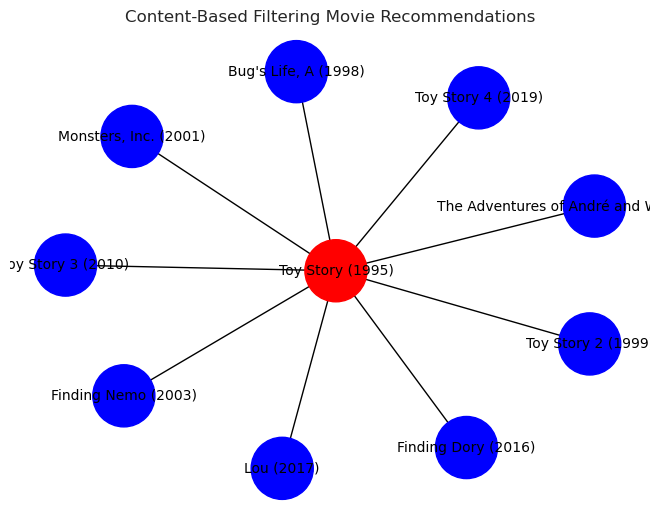

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Select a movie and its recommendations
selected_movie_id = 1
recommendations = get_movie_recommendations(selected_movie_id, top_n=10)
movie_name = recommendations.get(selected_movie_id).get('movie_name')
movie_id_array = [rec['movieId'] for rec in recommendations.get(selected_movie_id).get('recommended_movies')]

# Create a graph
G = nx.Graph()
G.add_node(selected_movie_id, label=movie_name, color='red')
for rec_id in movie_id_array:
    G.add_node(rec_id, label=movies_ml_25m[movies_ml_25m['movieId'] == rec_id]['title'].values[0])
    G.add_edge(selected_movie_id, rec_id)

# Draw the graph
pos = nx.spring_layout(G)
colors = ['red' if node == selected_movie_id else 'blue' for node in G.nodes]
labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, labels=labels, node_color=colors, node_size=2000, font_size=10)
plt.title('Content-Based Filtering Movie Recommendations')
plt.show()

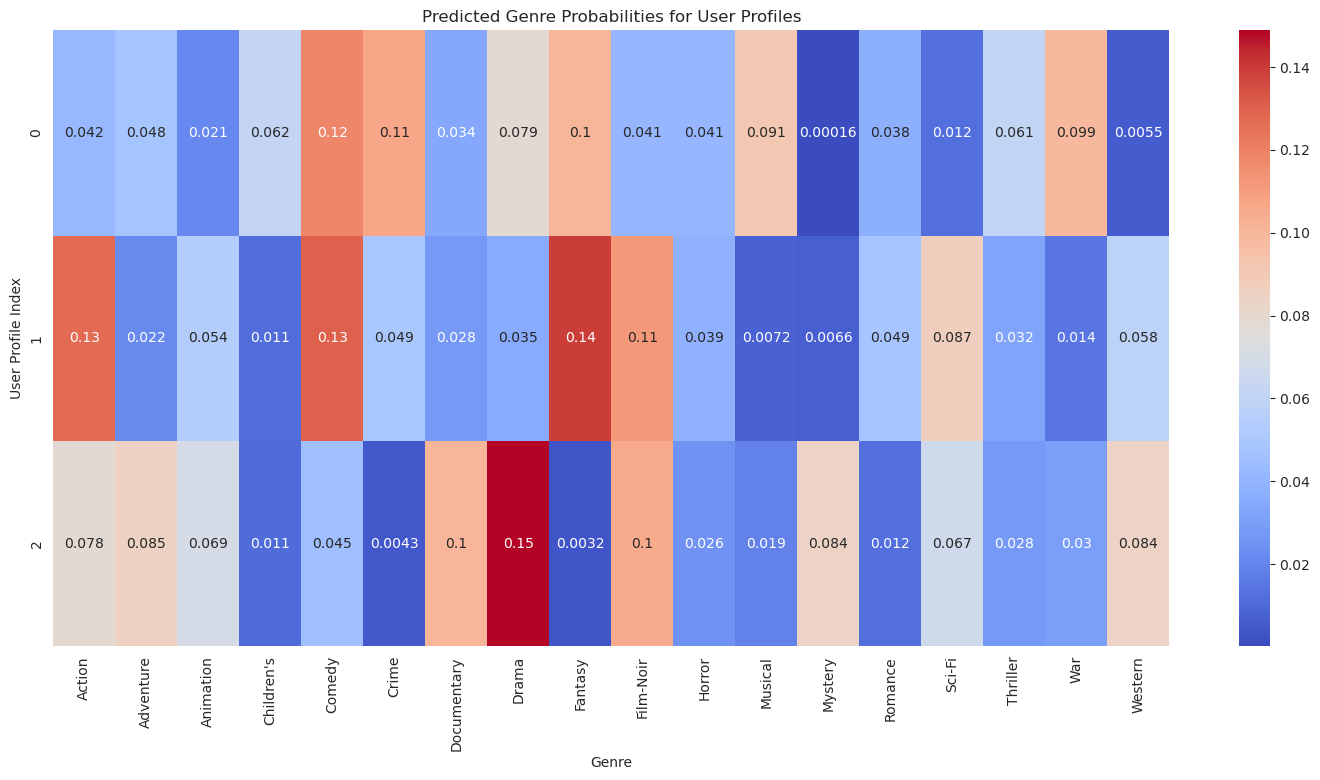

In [48]:
import seaborn as sns

# Example demographic profiles
user_profiles = pd.DataFrame({
    'age': [18, 25, 35],
    'gender': [1, 0, 1],  # 1 for male, 0 for female
    'occupation': [4, 12, 0]
})

# Generate mock genre probabilities for demonstration
genre_probabilities = np.random.rand(len(user_profiles), len(genre_columns))
genre_probabilities = genre_probabilities / genre_probabilities.sum(axis=1, keepdims=True)

# Plot heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_probabilities, annot=True, cmap='coolwarm', xticklabels=genre_columns)
plt.title('Predicted Genre Probabilities for User Profiles')
plt.xlabel('Genre')
plt.ylabel('User Profile Index')
plt.show()

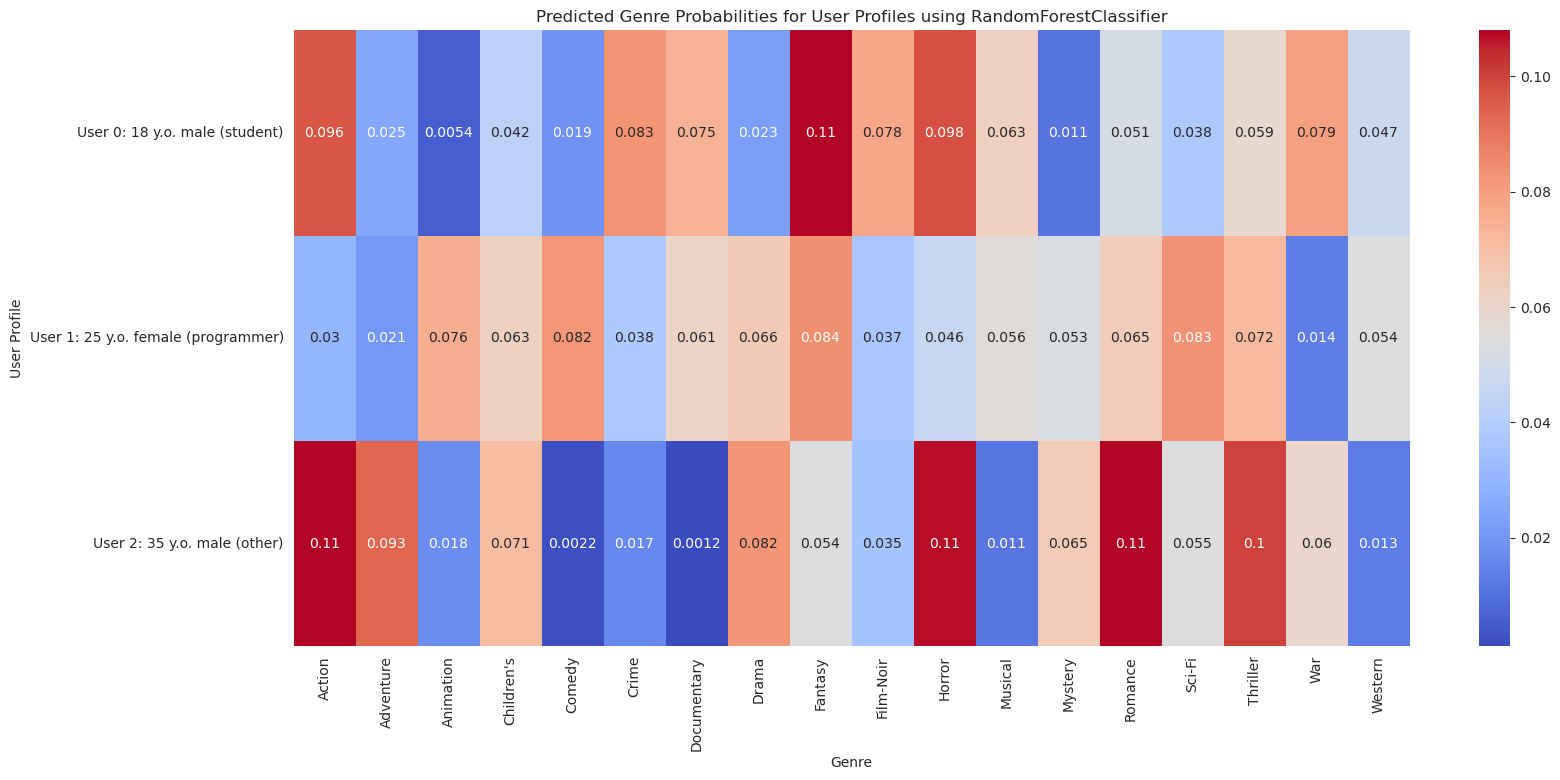

In [52]:
# Example demographic profiles
user_profiles = pd.DataFrame({
    'age': [18, 25, 35],
    'gender': ['male', 'female', 'male'],  # using string labels for clarity
    'occupation': ['student', 'programmer', 'other']  # descriptive occupation labels
})

# Generate mock genre probabilities for demonstration
genre_probabilities = np.random.rand(len(user_profiles), len(genre_columns))
genre_probabilities = genre_probabilities / genre_probabilities.sum(axis=1, keepdims=True)

# Custom labels for the y-axis
custom_labels = [f'User {idx}: {row["age"]} y.o. {row["gender"]} ({row["occupation"]})' for idx, row in user_profiles.iterrows()]

# Plot heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_probabilities, annot=True, cmap='coolwarm', xticklabels=genre_columns, yticklabels=custom_labels)
plt.title('Predicted Genre Probabilities for User Profiles using RandomForestClassifier')
plt.xlabel('Genre')
plt.ylabel('User Profile')
plt.show()